Source: https://www.tensorflow.org/tutorials/

In [31]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import random
import numpy as np
import matplotlib.pyplot as plt

TensorFlow version: 2.10.1


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [4]:
print (type(x_train))
print (x_train.shape)
print (y_train.shape)

<class 'numpy.ndarray'>
(60000, 28, 28, 1)
(60000,)


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [19]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [21]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [22]:
# only this step creates a computation graph
# rest all code outside of tf.function is eager execution
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [23]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [24]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
  )

Epoch 1, Loss: 0.13, Accuracy: 95.94, Test Loss: 0.06, Test Accuracy: 97.86
Epoch 2, Loss: 0.04, Accuracy: 98.66, Test Loss: 0.05, Test Accuracy: 98.27
Epoch 3, Loss: 0.02, Accuracy: 99.33, Test Loss: 0.05, Test Accuracy: 98.53
Epoch 4, Loss: 0.01, Accuracy: 99.58, Test Loss: 0.06, Test Accuracy: 98.29
Epoch 5, Loss: 0.01, Accuracy: 99.68, Test Loss: 0.06, Test Accuracy: 98.31


Actual label:  8
Predicted probabilities:  [[5.3158704e-14 3.0395103e-11 1.4302527e-11 1.0399933e-09 3.3726017e-12
  2.9342195e-10 7.2614335e-17 7.6413205e-09 1.0000000e+00 5.1954785e-08]]
Predicted label:  8  with probability:  1.0


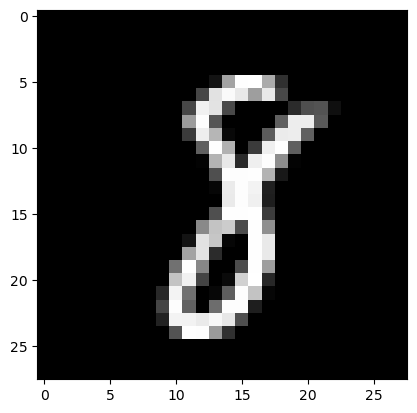

Actual label:  2
Predicted probabilities:  [[3.2534830e-14 4.8298637e-10 1.0000000e+00 3.5923698e-08 2.7953243e-08
  2.7300587e-13 3.7731272e-14 5.2254021e-12 1.0755353e-08 3.6373281e-13]]
Predicted label:  2  with probability:  1.0


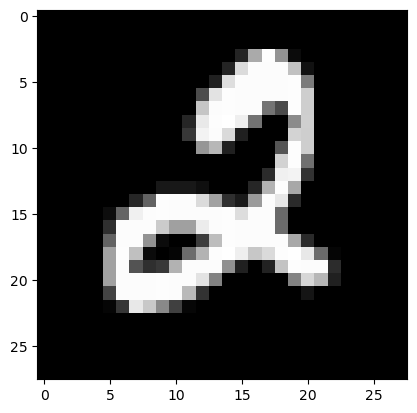

Actual label:  5
Predicted probabilities:  [[2.9542763e-19 1.3697400e-15 4.1224084e-18 2.4270383e-10 1.6961432e-18
  1.0000000e+00 1.2233581e-14 5.8545821e-20 2.3575484e-11 1.1159596e-11]]
Predicted label:  5  with probability:  1.0


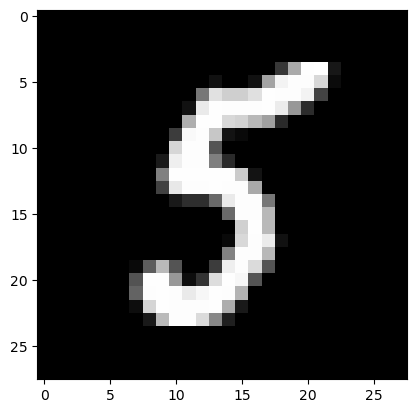

Actual label:  7
Predicted probabilities:  [[1.3260077e-12 3.5327767e-07 2.5082525e-11 6.0727970e-08 6.0449186e-04
  4.7112358e-06 2.6673526e-06 9.9938786e-01 3.1415337e-10 2.5954075e-10]]
Predicted label:  7  with probability:  0.99938786


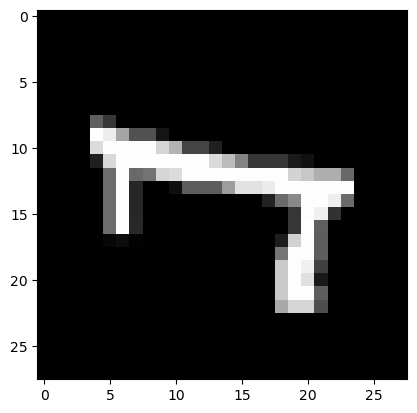

Actual label:  3
Predicted probabilities:  [[3.5705213e-12 2.7217345e-08 5.9309628e-12 9.9989820e-01 8.0149476e-14
  1.0148367e-04 1.8989765e-18 7.0908757e-10 3.0455146e-07 1.9355173e-08]]
Predicted label:  3  with probability:  0.9998982


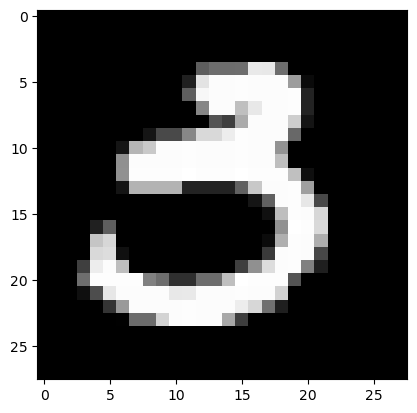

In [32]:
# see predictions on randomly picked samples
for _ in range(5):
    idx = random.randint(0, x_test.shape[0])
    data = x_test[idx]
    print ("Actual label: ", y_test[idx])
    predictions = tf.nn.softmax(model(data.reshape(1, 28, 28, 1))).numpy()
    print ("Predicted probabilities: ", predictions)
    print ("Predicted label: ", np.argmax(predictions), " with probability: ", np.max(predictions))
    plt.imshow(data, cmap='gray')
    plt.show()

Number of mistakes:  169
Number of correct predictions:  9831


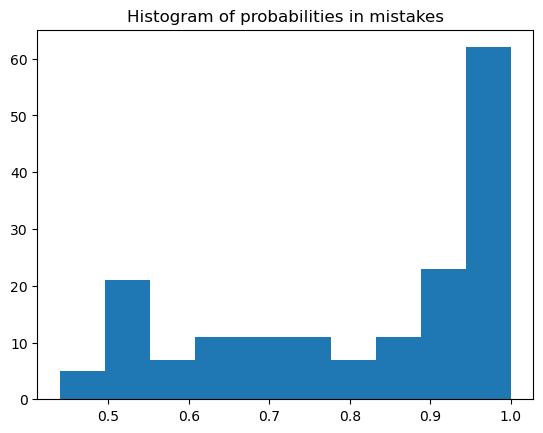

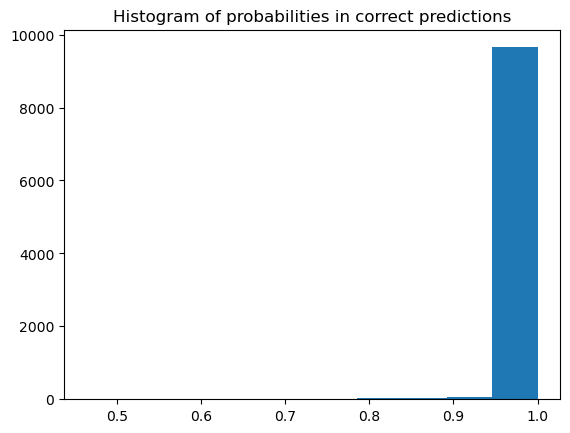

In [33]:
# see samples where the model is making most confident mistakes
mistakes = []
correct_predictions = []
all_predictions = tf.nn.softmax(model(x_test)).numpy()
for idx in range(x_test.shape[0]):
    actual_label = y_test[idx]
    predicted_label = np.argmax(all_predictions[idx])
    confidence = np.max(all_predictions[idx])
    if actual_label != predicted_label:
        mistakes.append((idx, actual_label, predicted_label, confidence))
    else:
        correct_predictions.append((idx, actual_label, predicted_label, confidence))

mistakes.sort(key=lambda x: x[3], reverse=True)
# show histogram of probabilities in mistakes v/s correct predictions
print ("Number of mistakes: ", len(mistakes))
print ("Number of correct predictions: ", len(correct_predictions))

mistakes = np.array(mistakes)
correct_predictions = np.array(correct_predictions)
plt.hist(mistakes[:, 3], bins=10)
plt.title("Histogram of probabilities in mistakes")
plt.show()

plt.hist(correct_predictions[:, 3], bins=10)
plt.title("Histogram of probabilities in correct predictions")
plt.show()

169  mistakes
Top 5 mistakes
Actual label:  6.0
Predicted label:  4.0  with confidence:  0.9999934434890747


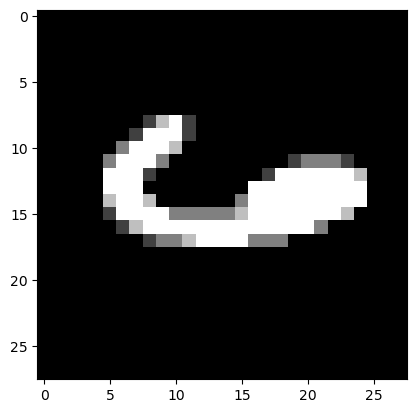

Actual label:  8.0
Predicted label:  0.0  with confidence:  0.9999886751174927


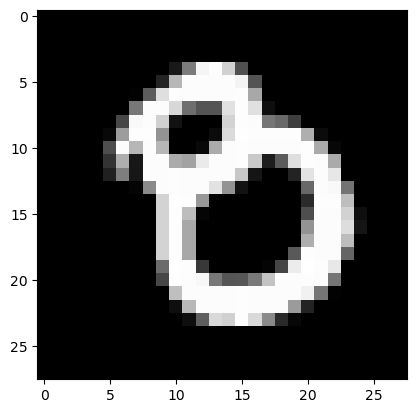

Actual label:  6.0
Predicted label:  1.0  with confidence:  0.9999845027923584


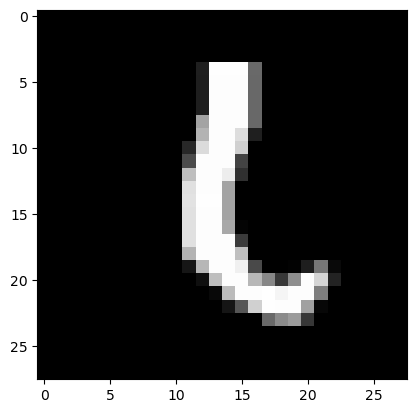

Actual label:  6.0
Predicted label:  0.0  with confidence:  0.9999833106994629


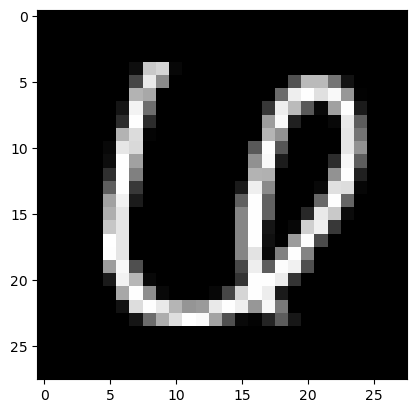

Actual label:  4.0
Predicted label:  9.0  with confidence:  0.9999053478240967


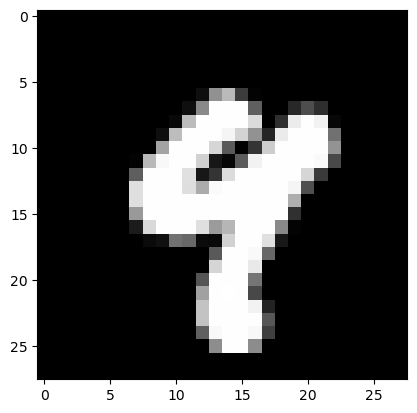

In [34]:
print (len(mistakes), " mistakes")
print ("Top 5 mistakes")
for idx, actual_label, predicted_label, confidence in mistakes[:5].tolist():
    print ("Actual label: ", actual_label)
    print ("Predicted label: ", predicted_label, " with confidence: ", confidence)
    plt.imshow(x_test[int(idx)], cmap='gray')
    plt.show()